<a href="https://colab.research.google.com/github/sg-tarek/Python/blob/main/Generate_fake_Trump_Tweets_(Using_GPT2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

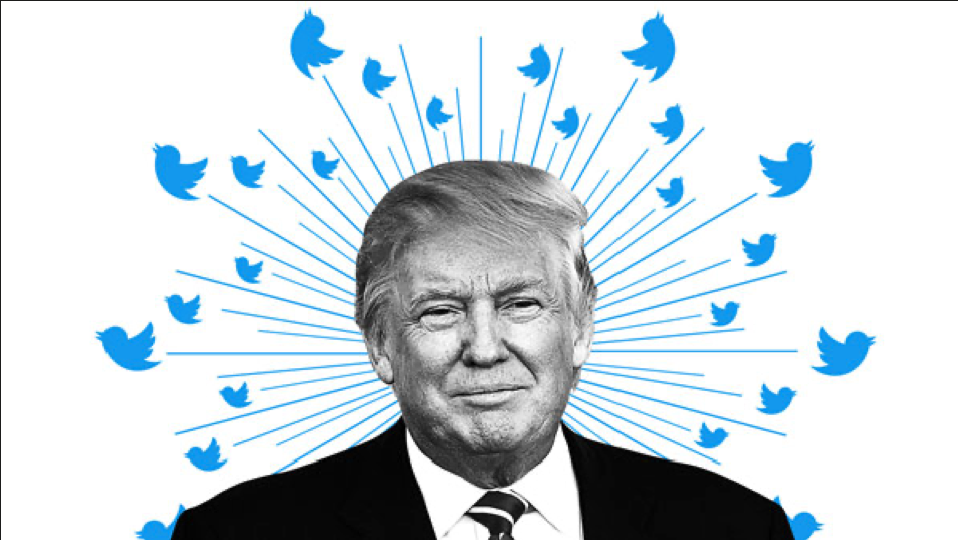

In this example we work with Trump tweets in order to create **fake** Trump Tweets. 
 
Transformer models are first trained on huge (and I mean huge) amounts of text in a step called “pre-training”. During this step, the models are expected to learn the words, grammar, structure, and other linguistic features of the language. This pre-trained model can then be fine-tuned on a variety of NLP tasks such as classification, named entity recognition, and question answering.
 
The data contains information of Trump tweets, when he posted, which device he used etc. We limit ourself to tweets which are not retweeted (which means he wrote them himself), written on his iphone and on tweets which are not deleted:

In [ ]:
!pip install simpletransformers

In [2]:
import pandas as pd

df = pd.read_json("https://www.dropbox.com/s/twxfxdln1l5gm3o/tweets_11-06-2020.zip?dl=1", compression='zip')
df = df[df['device'] == 'Twitter for iPhone']
df = df[df['isRetweet'] == 'f']

In [3]:
df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
1,1234653427789070300,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
3,1304875170860015600,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
6,1315779944002199600,"“I’m running as a proud Democrat, for the Sena...",f,f,Twitter for iPhone,149007,34897,2020-10-12 22:22:39
7,1223640662689689600,Getting a little exercise this morning! https:...,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02
8,1319501865625784300,https://t.co/4qwCKQOiOw,f,f,Twitter for iPhone,130822,19127,2020-10-23 04:52:14


In [4]:
#We now transform the tweets into a single list, where each tweet is only seperated by a comma:
tweets = df["text"].tolist()

We now create two files, one for the training (train.txt, which consist of all the tweets except the last 10) and one for the testing (test.txt, which consist of the last 10 tweets in the list). We use the open() function. The open() function takes two parameters; filename, and mode. There are four different methods (modes) for opening a file:
 
* "r" - Read - Default value. Opens a file for reading, error if the file does not exist
* "a" - Append - Opens a file for appending, creates the file if it does not exist
* "w" - Write - Opens a file for writing, creates the file if it does not exist
* "x" - Create - Creates the specified file, returns an error if the file exists
 
The writelines() method writes the items of a list to the file. Where the texts will be inserted depends on the file mode and stream position.
* "a":  The texts will be inserted at the current file stream position, default at the end of the file.
* "w": The file will be emptied before the texts will be inserted at the current file stream position, default 0.

In [5]:
with open("train.txt", "w") as f:
    for tweet in tweets[:-10]:
        f.writelines(tweet + "\n")

with open("test.txt", "w") as f:
    for tweet in tweets[-10:]:
        f.writelines(tweet + "\n")

In [ ]:
from simpletransformers.language_modeling import LanguageModelingModel

train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "train_batch_size": 32,
    "num_train_epochs": 5,
    "save_eval_checkpoints": False,
    "mlm": False,
    #"best_model_dir": "/content/drive/MyDrive/Colab/GPR2Trump/best" <-- after mounting google drive
}

model = LanguageModelingModel('gpt2', 'gpt2', args=train_args)

model.train_model("train.txt", eval_file="test.txt")

In [ ]:
model.eval_model("test.txt")

In [9]:
# Saving the quantized model
model.save_model("/content/GPR2Trump", model=model.model)

# Load the saved (quantized) model
#model = ClassificationModel('roberta', "outputs/quantized", use_cuda=False) <-- load trained model with another model type

Now this step is only optional. if you want to have more information on what's happening under the hood, activate the logger as follows:

In [10]:
import logging
from simpletransformers.language_generation import LanguageGenerationModel

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


model = LanguageGenerationModel('gpt2', "/content/GPR2Trump", args={"max_length": 100})

In [11]:
#Now we generate the [fake] tweet
model.generate('Denmark')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:Denmark, Denmark’s top official, is on the record as saying that the United Kingdom is a great partner for us, as we build out our Border Security and Economic Powers, and also keep our Tariffs at very reasonable levels. He’s not talking about the Great Barrier Wall!“The Wall and the Tax Cut”. “This is what’s going to be done.” Michael Goodwin (@FoxNews)  Thank you Michael. We’re


['Denmark, Denmark’s top official, is on the record as saying that the United Kingdom is a great partner for us, as we build out our Border Security and Economic Powers, and also keep our Tariffs at very reasonable levels. He’s not talking about the Great Barrier Wall!“The Wall and the Tax Cut”. “This is what’s going to be done.” Michael Goodwin (@FoxNews)  Thank you Michael. We’re']